A clean(er) version of FaceMatch.

#### Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import cv2
import os
import numpy as np
import random
from random import randrange
import math

#### Configure Device

In [3]:
if torch.cuda.is_available():
    dev = torch.device('cuda:0')
else:
    dev = torch.device('cpu')

# Data
## Load Data
#### Data Settings

In [4]:
negative_images_per_pos_image = 10
image_shape = (32, 32)

#### Data Utilities

In [26]:
# read an image from a path to a tensor and put it in the correct format
def load_image_to_tensor(path):
    img = image.imread(path)
    resize = cv2.resize(img, image_shape)
    tensor = torch.tensor(resize, device=dev)
    # put in N Channel Height Width format!
    permute = tensor.permute(2,0,1)
    return permute

# concatenates two images for input to the model
def make_input_from_images(img_a, img_b):
    cat = torch.cat((img_a, img_b), dim = 2)
    return cat

# generates an image from a pair of paths as stored in X in data
def make_input_from_paths(x):
    img_a = load_image_to_tensor(x[0])
    img_b = load_image_to_tensor(x[1])
    
    return torch.add(img_a, img_b)*(1/2)

# removes incorect files from an array of paths
def remove_ds(files):
    for f in files:
        if '.DS' in f:
            files.remove(f)
    return files

# show an example a dataset at a given index
def show_example(dataset, idx):
    idx_x, idx_y = dataset.__getitem__(idx)
    title = '\033[92m Positive Example \033[0m' if idx_y == 1 else '\033[93m Negative Example \033[0m'
    print(title)
    plt.imshow(idx_x.cpu().permute(1,2,0).int())
    plt.show()
    

    

#### Generate Dataset from Directory

In [6]:
# Creates a Dataset for use with a DataLoader
# Reads all images in a given folder into a dataset with given parameters
class FaceMatchDataset(torch.utils.data.Dataset):
    
    def __init__(self, directory, negative_examples_per_image=10):
        '''generate examples based on files'''
        x = np.array([[]])
        y = np.array([])
        people_images_dict = {}
        
        # each folder contains a list of people
        people_folders = os.listdir(directory)
        people_folters = remove_ds(people_folders)
        
        for person_folder in people_folders:
            images = os.listdir(directory + '/' + person_folder)
            images = remove_ds(images)
            image_paths = [] 
            for image in images:
                    image_paths.append(directory + '/' + person_folder + '/' + image)

            people_images_dict[person_folder] = image_paths
        
        for person in people_images_dict.keys():
            # get positive images
            positive_images = people_images_dict[person]
    
            # get negative images
            people_images_dict_keys = list(people_images_dict.keys())
            people_images_dict_keys.remove(person)
            negative_images = []

            for k in people_images_dict_keys:
                negative_images = negative_images + people_images_dict[k]
                
            #for each image
            for first_pos_image in positive_images:

                #make positive examples
                for second_pos_image in positive_images:
                    
                    positive_example = np.array([[first_pos_image, second_pos_image]])
                    if (x.size == 0):
                        x = positive_example
                    else:
                        x = np.append(x, positive_example, axis=0)
                    y = np.concatenate((y, [1]))
            
                #make negative examples
                for i in range(negative_examples_per_image):
                    random_negative_image_filename = negative_images[randrange(len(negative_images))]
                    if randrange(3) == 0:
                        negative_example = np.array([[random_negative_image_filename, first_pos_image]])
                        x = np.append(x, negative_example, axis=0)
                        y = np.concatenate((y, [0]))
                    else:
                        negative_example = np.array([[first_pos_image, random_negative_image_filename]])
                        x = np.append(x, negative_example, axis=0)
                        y = np.concatenate((y, [0]))
            
        
        self.x = x
        self.y = y
        
    
    def __len__(self):
        #return the number of examples
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        #make the example for the index
        idx_x = make_input_from_paths(self.x[idx])
        idx_y = torch.Tensor([self.y[idx]])
        
        return idx_x.float(), idx_y.float()
    
    def get_x_length(self):
        return self.x.shape[0]
    
    def get_y_length(self):
        return self.y.shape[0]

#### Genereate Training Data

In [42]:
train_dataset = FaceMatchDataset('TrainCroppedDataset', negative_examples_per_image=20)

#### Generate Test Data

In [9]:
test_dataset = FaceMatchDataset('TestCroppedDataset', negative_examples_per_image=negative_images_per_pos_image)

#### Save Dataset

In [47]:
path = 'train_ds_20neg.pt'
torch.save(train_dataset, path)

#### Load Dataset

In [32]:
path = 'train_ds_20neg.pt'
train_dataset = torch.load(path)

## Explore Data
#### Length

In [11]:
# print('Train Dataset Length: ' + str(train_dataset.__len__()) + ' items') 
print('Test Dataset Length: ' + str(test_dataset.__len__()) + ' items') 

Test Dataset Length: 1840 items


#### View at Example

 Positive Example 


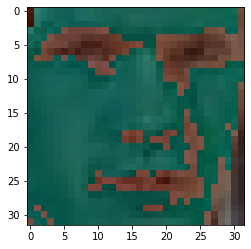

In [40]:
dataset = train_dataset
# dataset = test_dataset
idx = randrange(dataset.__len__())
# idx = 6
show_example(dataset, idx)

# Model
## Build Model
#### Network Utilities 

In [41]:
def test_example(example):
    model.eval()
    x, y = example
    net_inpt = torch.unsqueeze(x, 0)
    pred = model(net_inpt.float())

    print('\033[92mCorrect!\033[0m' if round(pred.cpu().detach().numpy()[0][0]) == y else '\033[93mWrong!\033[0m')
    print(('Positive Example' if y == 1 else 'Negative Example') + ' Prediction: ' + str(pred.cpu().detach().numpy()[0][0]))
    
    plt.imshow(x.cpu().permute(1,2,0).int())
    plt.show()
    
# Returns the % correct, number negative examples wrong, and the number positive examples wrong
def compute_average_acuracy_for_dataset(ds):
    model.eval()
    test_loader = torch.utils.data.DataLoader(ds, batch_size=64)
    y_hat = torch.Tensor([])
    y = torch.Tensor([])

    for batch_idx, (mini_x, mini_y) in enumerate(test_loader):
        with torch.no_grad():
            mini_y_hat = model(mini_x)
        y_hat = torch.cat((y_hat, mini_y_hat.cpu()))
        y = torch.cat((y, mini_y))

    num_right = 0
    num_neg_wrong = 0
    num_pos_wrong = 0
    for i in range(y.shape[0]):
        if round(y_hat[i].detach().numpy()[0]) == y[i]:
            num_right += 1
        elif y[i] == 0:
            num_neg_wrong += 1
        else:
            num_pos_wrong += 1
    return num_right / y.shape[0] * 100, num_neg_wrong, num_pos_wrong

def test_images(img_a, img_b):
    x = make_input_from_paths((img_a, img_b))
    y = model(x)
    return y

def test_images_and_show(img_a, img_b):
    x = make_input_from_paths((img_a, img_b))
    inpt = torch.unsqueeze(x, 0)
    y = model(inpt.to(dev).float())
    print('Prediction: ' + '\033[92mMatch\033[0m' if y > 0.5 else '\033[93mNot-Match\033[0m')
    pred_per = round(y[0][0].cpu().detach().numpy() * 100, 4)
    print('Output: ' + str(pred_per) + '%')
    plt.imshow(x.cpu().permute(1,2,0).int())
    plt.show()

#### Define Model

In [46]:
# Define the model
# 3 convolutional layers followed by 2 fully connected layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # layer 1
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 5, padding = 3)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        self.a1 = nn.ReLU()
        #norm???
        # layer 2
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.a2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 4)
        # layer 3
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.a3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = 4)
        #linear
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features = 32, out_features = 16)
        self.a4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features = 16, out_features = 1)
        self.a5 = nn.ReLU()
    

    def forward(self, x):
        # layer 1
        x = self.conv1(x)
        x = self.a1(x)
        x = self.pool1(x)
        
        # layer 2
        x = self.conv2(x)
        x = self.a2(x)
        x = self.pool2(x)
        
        #layer 3
        x = self.conv3(x)
        x = self.a3(x)
        x = self.pool3(x)
        
        #linear
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.a4(x)
        x = self.fc2(x)
#         x = torch.tanh(x)
        return(x)

## Initialize Model

In [47]:
model = Net()
model.to(dev);

## Train Model
#### Train Settings

In [51]:
batch_size = 64
num_epochs = 5
# learning_rate = 0.01

In [52]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = optim.Adadelta(model.parameters(), weight_decay = 1e-3)
loss_function = nn.MSELoss(reduction='sum')
model.train()

for epoch in range(num_epochs):
    print('Training Epoch ' + str(epoch + 1) + ' / ' + str( num_epochs), end='\r')
    
    for batch_idx, (mini_x, mini_y) in enumerate(train_loader):
        optimizer.zero_grad()
        mini_y_hat = model(mini_x.to(dev))
        loss = loss_function(mini_y_hat.cpu(), mini_y)
        loss.backward()
        optimizer.step()

optimizer.zero_grad()
print('Completed Training')

### Load Model

In [20]:
path = 'FaceMatch-test-57-train-82-lastfeb2.pt'
model = torch.load(path).to(dev)

### Save Model

In [114]:
path = 'FaceMatch-test-57-train-82-lastfeb2.pt'
torch.save(model, path)

## Explore Model

#### Test Example

Wrong!
Positive Example Prediction: 0.32539463


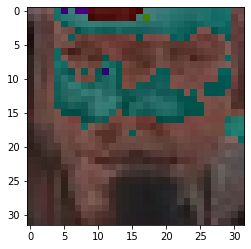

In [80]:
dataset = train_dataset
# dataset = test_dataset
idx = randrange(dataset.__len__())
# idx = 8
test_example(dataset.__getitem__(idx))

#### Test Entire Dataset

In [62]:
# dataset = train_dataset
dataset = test_dataset
per, nnw, npw = compute_average_acuracy_for_dataset(dataset)  
print('Accuracy: ' + str(per) + '%' + ' Missed Positives: ' + str(npw) + ' Missed Negatives: ' + str(nnw))



Accuracy: 44.29347826086957% Missed Positives: 936 Missed Negatives: 89


### Test Singles

In [81]:
henry0 = 'Testing/Henry0.jpeg'
henry1 = 'Testing/Henry1.jpeg'
andrew0 = 'Testing/Andrew0.jpeg'
andrew1 = 'Testing/Andrew1.jpeg'
andrew2 = 'Testing/Andrew2.jpeg'
andrew3 = 'Testing/Andrew3.jpeg'
andrewsbrother0 = 'Testing/AndrewsBrother0.jpeg'

clinton0 = 'TestData/clinton0.jpg'
jassy0 = 'TestData/jassy0.jpg'
h0 = 'TestData/HannibalBuress.jpg'

Not-Match
Output: 49.5949%


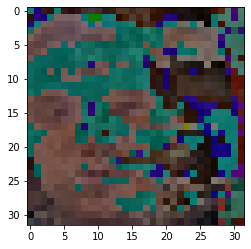

In [83]:
img_a = h0
img_b = henry1

test_images_and_show(img_a, img_b)
# test_images_and_show(img_b, img_a)

## Lab

In [107]:

def get_pos_neg_examples(dataset):
    pos_ex = 0
    neg_ex = 0

    for idx in range(dataset.__len__()):
        x, y = dataset.__getitem__(idx)
        if y == 1:
            pos_ex += 1
        else:
            neg_ex += 1
            
    return pos_ex, neg_ex

test_pos_ex, test_neg_ex = get_pos_neg_examples(test_dataset)
print('Test Dataset Positive Examples: ' + str(test_pos_ex) + ' Negative Examples: ' + str(test_neg_ex))
train_pos_ex, train_neg_ex = get_pos_neg_examples(train_dataset)
print('Train Dataset Positive Examples: ' + str(train_pos_ex) + ' Negative Examples: ' + str(train_neg_ex))
    

Test Dataset Positive Examples: 1040 Negative Examples: 800
Train Dataset Positive Examples: 22722 Negative Examples: 25640


In [108]:
22822/25640


0.8900936037441498